In [191]:
combine_df = []
for file_ in ['/Users/smukherjee5/cs109_final_project/cs109a/data/tweets_nlp_1_2.csv','/Users/smukherjee5/cs109_final_project/cs109a/data/tweets_nlp_2_2.csv','/Users/smukherjee5/cs109_final_project/cs109a/data/tweets_nlp_3_2.csv']:
    df = pd.read_csv(file_,index_col=None, header=0,keep_default_na=False)
    combine_df.append(df)
all_tweets = pd.concat(combine_df, axis = 0, ignore_index = True)    
display(train_base_tweets_df.head(2))
print('train tweets shape:',train_base_tweets_df.shape)
print('test tweets shape:',test_base_tweets_df.shape)

,retweet_count,favorite_count,num_hashtags,num_urls,num_mentions,user_type,sentiment_negative,sentiment_neutral,sentiment_positive,ratio_pos,ratio_neg,ratio_neu,token_count,url_token_ratio,ant,disgust,fear,joy,sadness,surprise,trust,jaccard
54933,0,0,0,1,0,0,0,0,1,0.755000,0.087813,0.157188,84,0.011905,0,0,0,0,0,0,0,0.002564
80644,0,0,0,1,0,0,0,1,0,0.415938,0.080625,0.503437,139,0.007194,0,0,0,0,0,0,0,0.013371


train tweets shape: (80574, 22)
test tweets shape: (39686, 22)


Ref: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0197775
     https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3813439/
     https://rdrr.io/cran/quanteda/man/textstat_lexdiv.html


### Lexical Diversity Features

Listed below are some sophisticated techniques that have been developed to measure LD.

ttr- The Type-Token Ratio represents the most used and intuitive way to measure lexical diversity on the basis of word repetition patterns. TTR consists in expressing the number of different words “as a proportion of the total number of words.”
The higher the probability that a new word token is also a new word type, the closer the TTR is to 1, and the greater the lexical diversity of that text.
In the case of lexical diversity measurement, a common strategy used to cope with sample size dependency consists in finding an adequate mathematical expression of the type count slowdown in order to counterbalance its effect on the TTR.


In the case of lexical diversity measurement, a common strategy used to cope with sample size dependency consists in finding an adequate mathematical expression of the type count slowdown in order to counterbalance its effect on the TTR. 

root_ttr - Various attempts were made in this regard: some studies assumed that the ratio fall is proportional to the square root of the token count

log_ttr - Attempt to ‘linearize’ the same ratio fall through various logarithmic transformations

mtld -  Strategy that has so far successfully dealt with the sample size dependency of the TTR or any TTR-based measure consists in controlling for sample upsizing through fixed size sampling procedures.

HD-D - index derived directly from the hypergeometric distribution

Yule-k - . The measure of lexical repetition constitutes one of the variables used to determine
the lexical diversity of texts.Although most of the constants for lexical richness actually depend on text length, Yule’s characteristic is considered to be highly reliable for being text length independent

In [199]:
from collections import Counter, defaultdict
from math import sqrt, log
from nltk import word_tokenize
import numpy as np
import pandas as pd

import os

def ttr(text):
    tok_text = word_tokenize(text)
    return len(set(tok_text)) / len(tok_text)

def root_ttr(text):
    return sqrt(ttr(text))

def corrected_ttr(text):
    tok_text = word_tokenize(text)
    return sqrt(len(set(tok_text)) / (2 * len(tok_text)))

def log_ttr(text):
    tok_text = word_tokenize(text)
    if log(len(tok_text),2) == 0:
        print(text)
        return 0
    return log(len(set(tok_text)),2) / log(len(tok_text),2)

def uber_index(text):
    tok_text = word_tokenize(text)
    if log(len(tok_text),2) != 0 and log(len(set(tok_text)),2) != 0:
        return (log(len(tok_text),2) ** 2) / (log(len(set(tok_text)),2) / log(len(tok_text),2))
    else:
        return 0
    
def yule_s_k(text):
    tok_text = word_tokenize(text)
    token_counter = Counter(tok.upper() for tok in tok_text)
    m1 = sum(token_counter.values())
    m2 = sum([freq ** 2 for freq in token_counter.values()])
    if m2-m1 != 0:
        i = (m1*m1) / (m2-m1)
        k = 10000 / i
        return k

In [200]:
#Copyright 2017 John Frens
#
#Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
#
#The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
#
#THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

import string

# Global trandform for removing punctuation from words
remove_punctuation = str.maketrans('', '', string.punctuation)

# MTLD internal implementation
def mtld_calc(word_array, ttr_threshold):
    current_ttr = 1.0
    token_count = 0
    type_count = 0
    types = set()
    factors = 0.0
    
    for token in word_array:
        token = token.translate(remove_punctuation).lower() # trim punctuation, make lowercase
        token_count += 1
        if token not in types:
            type_count +=1
            types.add(token)
        current_ttr = type_count / token_count
        if current_ttr <= ttr_threshold:
            factors += 1
            token_count = 0
            type_count = 0
            types = set()
            current_ttr = 1.0
    
    excess = 1.0 - current_ttr
    excess_val = 1.0 - ttr_threshold
    factors += excess / excess_val
    if factors != 0:
        return len(word_array) / factors
    return -1

# MTLD implementation
def mtld(word_array, ttr_threshold=0.72):
    word_array = word_tokenize(word_array)
    
    return (mtld_calc(word_array, ttr_threshold) + mtld_calc(word_array[::-1], ttr_threshold)) / 2


# HD-D internals

# x! = x(x-1)(x-2)...(1)
def factorial(x):
    if x <= 1:
        return 1
    else:
        return x * factorial(x - 1)

# n choose r = n(n-1)(n-2)...(n-r+1)/(r!)
def combination(n, r):
    r_fact = factorial(r)
    numerator = 1.0
    num = n-r+1.0
    while num < n+1.0:
        numerator *= num
        num += 1.0
    return numerator / r_fact

# hypergeometric probability: the probability that an n-trial hypergeometric experiment results 
#  in exactly x successes, when the population consists of N items, k of which are classified as successes.
#  (here, population = N, population_successes = k, sample = n, sample_successes = x)
#  h(x; N, n, k) = [ kCx ] * [ N-kCn-x ] / [ NCn ]
def hypergeometric(population, population_successes, sample, sample_successes):
    return (combination(population_successes, sample_successes) *\
            combination(population - population_successes, sample - sample_successes)) /\
            combination(population, sample)
    
# HD-D implementation
def hdd(word_array, sample_size=42.0):
    word_array = word_tokenize(word_array)
    
    # Create a dictionary of counts for each type
    type_counts = {}
    for token in word_array:
        token = token.translate(remove_punctuation).lower() # trim punctuation, make lowercase
        if token in type_counts:
            type_counts[token] += 1.0
        else:
            type_counts[token] = 1.0
    # Sum the contribution of each token - "If the sample size is 42, the mean contribution of any given
    #  type is 1/42 multiplied by the percentage of combinations in which the type would be found." (McCarthy & Jarvis 2010)
    hdd_value = 0.0
    for token_type in type_counts.keys():
        contribution = (1.0 - hypergeometric(len(word_array), sample_size, type_counts[token_type], 0.0)) / sample_size
        hdd_value += contribution

    return hdd_value

In [201]:
LD_feature_functions = [ttr, root_ttr, corrected_ttr, log_ttr, uber_index, yule_s_k, mtld, hdd]

In [202]:
def save_df(path,df):
    df.to_csv(path,index=False)

for input_file in ['/Users/smukherjee5/cs109_final_project/cs109a/data/tweets_nlp_1_2.csv','/Users/smukherjee5/cs109_final_project/cs109a/data/tweets_nlp_2_2.csv','/Users/smukherjee5/cs109_final_project/cs109a/data/tweets_nlp_3_2.csv']:
    print(input_file)
    df = pd.read_csv(input_file,index_col=None, header=0,keep_default_na=False)

    for function in LD_feature_functions:
        df["LD-"+function.__name__]  = [function(text) for text in df["text"]]

    filename = input_file.replace('.csv','')+'_ld.csv'
    save_df(filename, df)

/Users/smukherjee5/cs109_final_project/cs109a/data/tweets_nlp_1_2.csv
Zzzzzzzzzzzzzzzzz
88.8
Goodnight 
Beach 
Earthquake 
كرك 
divergent
3-1 
Gm 
Happy 
Hahahahaha 
Gm 
Surprise 
الحمدالله 
❤️
GN
GN
Bored
mbc3♥
我非常真很累死了得不得了
你好，台南！
Hobbaloopa 
testing
test
no
Nothing
wiggy
drake
georgina
lucy
chloe
billi
billie
sam
lydia
gemma
popey
diags
ronnie
korn
haha
motherboy
MKiss
-_-
Afraaaaah
Hungry
Starbucks
later
GoodMorning
❤️❤️❤️❤️
Done
Hi
Traffic 
✈️✈️✈️✈️
Barney 
12/13/14
Tomorrow
Hahahahahah
Fireball
Hi
Magnum
Hi
Bored
Hello
Lucy
Hi
GoodMorning
Hahahahahahaha
GoodNight•____•School 
☀️☀️☀️☀️☀️☀️☀️☀️
boring
Earthquake 
Okay 
Gabbers 
Childish
Ugly
Hungry
And
Bored
Pizzzzzzaaaaaaaaaaaaa
Yogurt
Wtf..
Bittersweet 
Awesome 
IDGAF
College 
✊
-____________- 
EARTHQUAKKKKKE
BRRRRRRRRAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAINNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNFRRRREEEEEEEEEEEEZEEEEEEEEEE-
fdhf
QUICKLY
Idk
SEDAL
NOW
ASDFGHJKL
mngbfvdcsa
kk
Milestones
Jantelagen
すかれた。。
Requ

In [203]:
combine_df = []
for file_ in ['/Users/smukherjee5/cs109_final_project/cs109a/data/tweets_nlp_1_2_ld.csv','/Users/smukherjee5/cs109_final_project/cs109a/data/tweets_nlp_2_2_ld.csv','/Users/smukherjee5/cs109_final_project/cs109a/data/tweets_nlp_3_2_ld.csv']:
    df = pd.read_csv(file_,index_col=None, header=0,keep_default_na=False)
    combine_df.append(df)
all_tweets = pd.concat(combine_df, axis = 0, ignore_index = True)  

In [221]:
all_tweets_df = all_tweets[['retweet_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions',
                               'user_type', 'sentiment_negative', 'sentiment_neutral', 'sentiment_positive',
                               'ratio_pos', 'ratio_neg', 'ratio_neu', 'token_count', 'url_token_ratio', 'ant',
                               'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust','jaccard','LD-ttr','LD-root_ttr','LD-corrected_ttr','LD-log_ttr','LD-uber_index','LD-yule_s_k','LD-mtld','LD-hdd']]


Scatter Matrix for Lexical Diversity


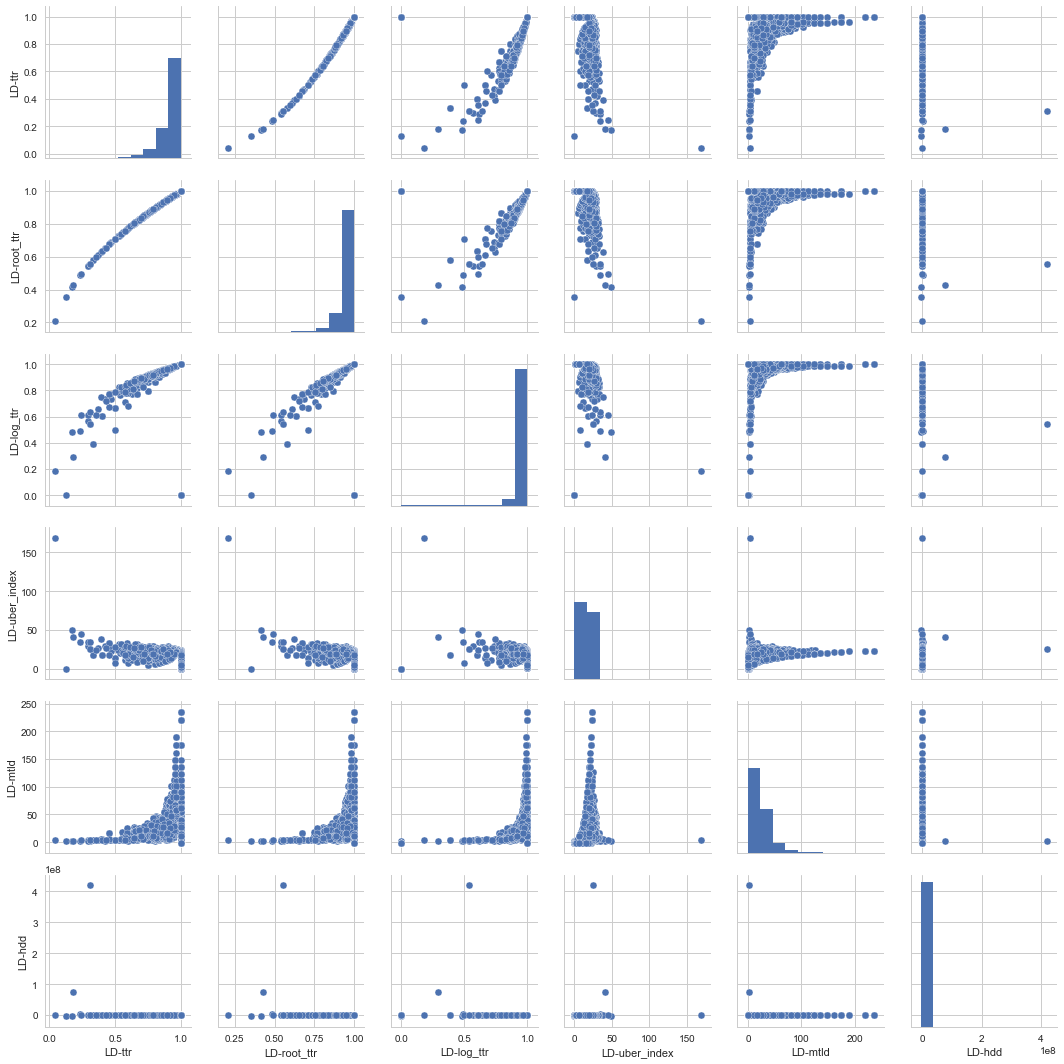

In [223]:
import seaborn as sns;
tweets_ld = all_tweets[['LD-ttr', 'LD-root_ttr', 'LD-log_ttr','LD-uber_index','LD-yule_s_k','LD-mtld','LD-hdd']]
tweets_ld_sample = resample(tweets_ld, n_samples=5000, replace=False)
g = sns.pairplot(tweets_ld_sample)
print('Scatter Matrix for Lexical Diversity')
g.savefig('twitter-ld')


In [226]:
from sklearn.feature_selection import VarianceThreshold
def variance_threshold_selector(data, threshold=0.5):
    #https://stackoverflow.com/questions/39812885/retain-feature-names-after-scikit-feature-selection
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]


In [273]:
tweets_all_var = all_tweets_df[['retweet_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions',\
                                 'user_type', 'sentiment_negative', 'sentiment_neutral', 'sentiment_positive',\
                                 'ratio_pos', 'ratio_neg', 'ratio_neu', 'token_count','url_token_ratio', \
                                 'ant','disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust', 'jaccard','LD-ttr','LD-root_ttr','LD-corrected_ttr','LD-log_ttr','LD-uber_index','LD-yule_s_k','LD-mtld','LD-hdd']]

tweets_all_var[['LD-yule_s_k']] = tweets_all_var[['LD-yule_s_k']].fillna(0)

def convert_float(val):
    try:
        return float(val)
    except ValueError:
        return 0

tweets_all_var['LD-yule_s_k']=tweets_all_var['LD-yule_s_k'].apply(lambda x: convert_float(x))
tweets_all_var
features = variance_threshold_selector(tweets_all_var, threshold=(.95*.1)).columns

In [274]:
features

Index(['retweet_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions', 'user_type', 'sentiment_negative', 'sentiment_neutral', 'sentiment_positive', 'token_count', 'ant', 'fear', 'joy', 'trust', 'LD-uber_index', 'LD-yule_s_k', 'LD-mtld', 'LD-hdd'], dtype='object')